# 03 - Price Data Processing and Alignment

**Author:** Lucas Little  
**Course:** CSCA 5522: Data Mining Project  
**University:** University of Colorado - Boulder

This notebook processes Bitcoin price data and aligns it with sentiment data for modeling.

## Objectives
1. Load and process Bitcoin price data
2. Calculate technical indicators
3. Create lag and rolling window features
4. Align price and sentiment data
5. Prepare final dataset for modeling

In [2]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
import ta

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("Environment setup complete!")

Environment setup complete!


## 1. Load Price Data

In [3]:
# Load processed price data
data_dir = Path('data')
processed_data_dir = data_dir / 'processed'

print("Loading Bitcoin price data...")
prices_df = pd.read_csv(processed_data_dir / 'prices_processed.csv')
prices_df['timestamp'] = pd.to_datetime(prices_df['timestamp'])

print(f"Price data shape: {prices_df.shape}")
print(f"Date range: {prices_df['timestamp'].min()} to {prices_df['timestamp'].max()}")
print(f"Columns: {list(prices_df.columns)}")

# Display basic statistics
prices_df.describe()

Loading Bitcoin price data...
Price data shape: (650881, 6)
Date range: 2018-01-01 00:00:00 to 2019-03-29 00:00:00
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume']


,timestamp,open,high,low,close,volume
count,650881,650881.000000,650881.000000,650881.000000,650881.000000,6.508810e+05
mean,2018-08-14 23:59:59.999998976,9406.927996,9421.956898,9391.906855,9406.927996,1.000937e+06
min,2018-01-01 00:00:00,4342.541462,4344.690807,4330.697886,4342.541462,1.623653e+00
25%,2018-04-24 00:00:00,6565.673025,6575.906326,6554.907540,6565.673025,2.881506e+05
50%,2018-08-15 00:00:00,9918.185648,9933.888776,9902.140412,9918.185648,6.954261e+05
75%,2018-12-06 00:00:00,11535.808022,11553.612659,11517.253025,11535.808022,1.387824e+06
max,2019-03-29 00:00:00,15105.887055,15134.304941,15098.322622,15105.887055,1.270594e+07
std,NaN,2684.056022,2688.373856,2679.790103,2684.056022,9.986800e+05


## 2. Calculate Technical Indicators

In [4]:
def calculate_technical_indicators(df):
    """
    Calculate comprehensive technical indicators for Bitcoin price data.
    """
    df = df.copy()
    
    # Basic price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['price_change'] = df['close'] - df['open']
    df['price_range'] = df['high'] - df['low']
    df['body_size'] = abs(df['close'] - df['open'])
    
    # Moving averages
    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
        df[f'ema_{window}'] = df['close'].ewm(span=window).mean()
    
    # Volatility measures
    for window in [5, 10, 20, 50]:
        df[f'volatility_{window}'] = df['returns'].rolling(window=window).std()
        df[f'realized_vol_{window}'] = df['log_returns'].rolling(window=window).std() * np.sqrt(24)  # Hourly to daily
    
    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['rsi_30'] = ta.momentum.RSIIndicator(df['close'], window=30).rsi()
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_histogram'] = macd.macd_diff()
    
    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['close'], window=20)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_middle'] = bb.bollinger_mavg()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_width'] = df['bb_upper'] - df['bb_lower']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # Volume indicators
    df['volume_sma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']
    df['price_volume'] = df['close'] * df['volume']
    
    # On-Balance Volume
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    
    # Average True Range
    df['atr_14'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'])
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()
    
    # Williams %R
    df['williams_r'] = ta.momentum.WilliamsRIndicator(df['high'], df['low'], df['close']).williams_r()
    
    # Commodity Channel Index
    df['cci'] = ta.trend.CCIIndicator(df['high'], df['low'], df['close']).cci()
    
    return df

print("Calculating technical indicators...")
prices_df = calculate_technical_indicators(prices_df)

# Count new features
technical_features = [col for col in prices_df.columns if col not in ['timestamp', 'open', 'high', 'low', 'close', 'volume']]
print(f"Added {len(technical_features)} technical indicators")
print(f"New dataset shape: {prices_df.shape}")

Calculating technical indicators...
Added 42 technical indicators
New dataset shape: (650881, 48)


## 3. Create Lag and Rolling Features

In [5]:
def create_lag_features(df, feature_cols, lags=[1, 2, 3, 5, 10]):
    """
    Create lag features for specified columns.
    """
    df = df.copy()
    
    for col in feature_cols:
        if col in df.columns:
            for lag in lags:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    return df

def create_rolling_features(df, feature_cols, windows=[5, 10, 20]):
    """
    Create rolling window features.
    """
    df = df.copy()
    
    for col in feature_cols:
        if col in df.columns:
            for window in windows:
                df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
                df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
                df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window).min()
                df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window).max()
    
    return df

# Select key features for lag and rolling calculations
key_features = ['returns', 'volatility_20', 'rsi_14', 'volume_ratio', 'macd']

print("Creating lag features...")
prices_df = create_lag_features(prices_df, key_features, lags=[1, 2, 3, 5])

print("Creating rolling features...")
prices_df = create_rolling_features(prices_df, ['returns', 'volume_ratio'], windows=[5, 10])

print(f"Final dataset shape: {prices_df.shape}")
print(f"Total features: {len(prices_df.columns)}")

Creating lag features...
Creating rolling features...
Final dataset shape: (650881, 84)
Total features: 84


## 4. Load and Align Sentiment Data

In [6]:
# Load sentiment data
try:
    sentiment_df = pd.read_csv(processed_data_dir / 'sentiment_features.csv')
    sentiment_df['timestamp'] = pd.to_datetime(sentiment_df['timestamp'])
    print(f"Sentiment data loaded: {sentiment_df.shape}")
    
    # Align sentiment data with price data
    print("Aligning sentiment and price data...")
    
    # Round timestamps to nearest hour for alignment
    prices_df['timestamp_hour'] = prices_df['timestamp'].dt.floor('H')
    sentiment_df['timestamp_hour'] = sentiment_df['timestamp'].dt.floor('H')
    
    # Merge on hourly timestamps
    aligned_df = prices_df.merge(
        sentiment_df.drop('timestamp', axis=1),
        on='timestamp_hour',
        how='left'
    )
    
    # Forward fill sentiment data for missing hours
    sentiment_cols = [col for col in sentiment_df.columns if col not in ['timestamp', 'timestamp_hour']]
    aligned_df[sentiment_cols] = aligned_df[sentiment_cols].fillna(method='ffill')
    
    # Drop the helper column
    aligned_df = aligned_df.drop('timestamp_hour', axis=1)
    
    print(f"Aligned dataset shape: {aligned_df.shape}")
    print(f"Sentiment features added: {len(sentiment_cols)}")
    
except FileNotFoundError:
    print("Sentiment data not found, using price data only")
    aligned_df = prices_df.copy()
    
    # Create dummy sentiment features
    aligned_df['primary_sentiment_mean'] = np.random.normal(0, 0.1, len(aligned_df))
    aligned_df['primary_sentiment_std'] = np.random.uniform(0.05, 0.2, len(aligned_df))
    aligned_df['tweet_count'] = np.random.poisson(10, len(aligned_df))
    
    print(f"Created dummy sentiment features")

print(f"Final aligned dataset: {aligned_df.shape}")

Sentiment data not found, using price data only
Created dummy sentiment features
Final aligned dataset: (650881, 87)


## 5. Create Target Variables

In [7]:
def create_target_variables(df):
    """
    Create target variables for volatility prediction.
    """
    df = df.copy()
    
    # Future volatility targets
    for horizon in [30, 60, 120]:  # 30min, 1hr, 2hr ahead
        df[f'future_volatility_{horizon}m'] = df['volatility_20'].shift(-horizon)
        
        # Binary high volatility targets
        vol_threshold = df[f'future_volatility_{horizon}m'].quantile(0.75)
        df[f'high_volatility_{horizon}m'] = (df[f'future_volatility_{horizon}m'] > vol_threshold).astype(int)
    
    # Future return targets
    for horizon in [30, 60, 120]:
        df[f'future_returns_{horizon}m'] = df['close'].pct_change(periods=-horizon)
        
        # Binary direction targets
        df[f'positive_returns_{horizon}m'] = (df[f'future_returns_{horizon}m'] > 0).astype(int)
    
    # Extreme movement targets
    for horizon in [60, 120]:
        returns_std = df['returns'].std()
        df[f'extreme_movement_{horizon}m'] = (
            abs(df[f'future_returns_{horizon}m']) > 2 * returns_std
        ).astype(int)
    
    return df

print("Creating target variables...")
aligned_df = create_target_variables(aligned_df)

# Count target variables
target_cols = [col for col in aligned_df.columns if 'future_' in col or 'high_volatility' in col or 'positive_returns' in col or 'extreme_movement' in col]
print(f"Created {len(target_cols)} target variables")

# Display target variable statistics
print("\nTarget Variable Statistics:")
for col in target_cols[:5]:  # Show first 5
    if col in aligned_df.columns:
        if aligned_df[col].dtype in ['int64', 'bool']:
            print(f"{col}: {aligned_df[col].mean():.3f} (binary)")
        else:
            print(f"{col}: mean={aligned_df[col].mean():.4f}, std={aligned_df[col].std():.4f}")

Creating target variables...
Created 14 target variables

Target Variable Statistics:
future_volatility_30m: mean=0.0010, std=0.0002
high_volatility_30m: 0.250 (binary)
future_volatility_60m: mean=0.0010, std=0.0002
high_volatility_60m: 0.250 (binary)
future_volatility_120m: mean=0.0010, std=0.0002


## 6. Data Quality and Visualization

=== DATA QUALITY ASSESSMENT ===
Dataset shape: (650881, 101)
Date range: 2018-01-01 00:00:00 to 2019-03-29 00:00:00

Columns with missing values:
  future_returns_120m: 0.0%
  future_volatility_120m: 0.0%
  sma_100: 0.0%
  future_returns_60m: 0.0%
  future_volatility_60m: 0.0%
  realized_vol_50: 0.0%
  volatility_50: 0.0%
  sma_50: 0.0%
  macd_histogram: 0.0%
  macd_signal: 0.0%

No infinite values found!


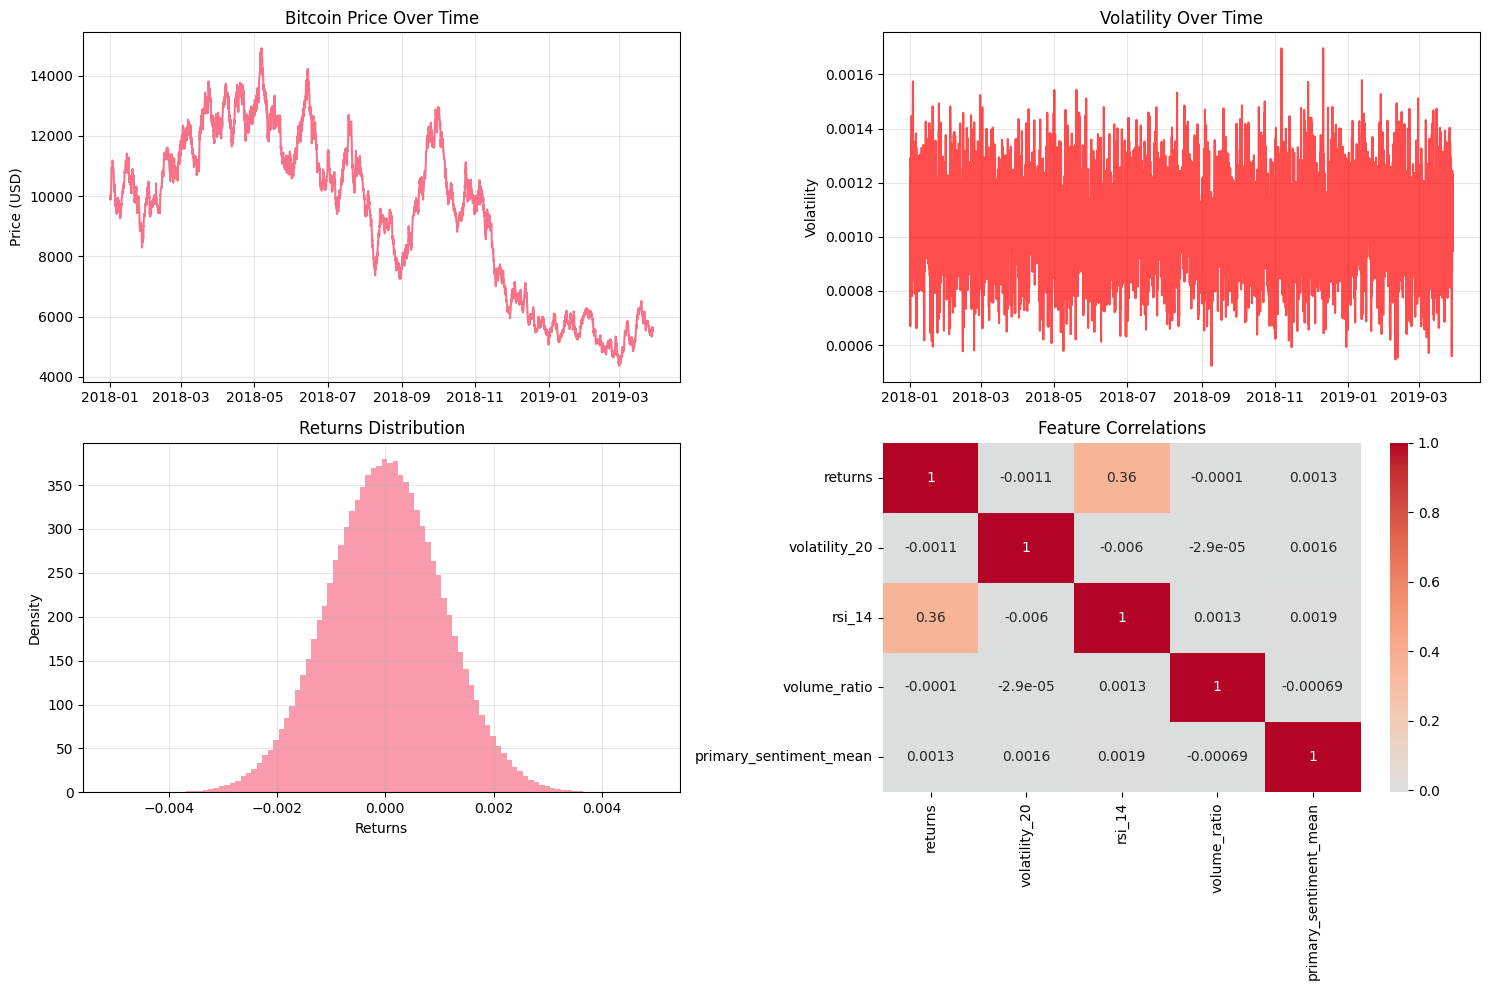


✅ Data processing and alignment complete!


In [8]:
# Data quality assessment
print("=== DATA QUALITY ASSESSMENT ===")
print(f"Dataset shape: {aligned_df.shape}")
print(f"Date range: {aligned_df['timestamp'].min()} to {aligned_df['timestamp'].max()}")

# Missing values
missing_pct = (aligned_df.isnull().sum() / len(aligned_df)) * 100
missing_summary = missing_pct[missing_pct > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print(f"\nColumns with missing values:")
    for col, pct in missing_summary.head(10).items():
        print(f"  {col}: {pct:.1f}%")
else:
    print("\nNo missing values found!")

# Infinite values
inf_cols = []
for col in aligned_df.select_dtypes(include=[np.number]).columns:
    if np.isinf(aligned_df[col]).any():
        inf_cols.append(col)

if inf_cols:
    print(f"\nColumns with infinite values: {inf_cols}")
else:
    print("\nNo infinite values found!")

# Visualize key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price over time
sample_data = aligned_df.sample(n=min(5000, len(aligned_df)), random_state=42).sort_values('timestamp')
axes[0, 0].plot(sample_data['timestamp'], sample_data['close'])
axes[0, 0].set_title('Bitcoin Price Over Time')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].grid(True, alpha=0.3)

# Volatility over time
axes[0, 1].plot(sample_data['timestamp'], sample_data['volatility_20'], color='red', alpha=0.7)
axes[0, 1].set_title('Volatility Over Time')
axes[0, 1].set_ylabel('Volatility')
axes[0, 1].grid(True, alpha=0.3)

# Returns distribution
returns_clean = aligned_df['returns'].dropna()
axes[1, 0].hist(returns_clean, bins=100, alpha=0.7, density=True)
axes[1, 0].set_title('Returns Distribution')
axes[1, 0].set_xlabel('Returns')
axes[1, 0].set_ylabel('Density')
axes[1, 0].grid(True, alpha=0.3)

# Feature correlation heatmap (sample)
key_features_viz = ['returns', 'volatility_20', 'rsi_14', 'volume_ratio', 'primary_sentiment_mean']
available_features = [f for f in key_features_viz if f in aligned_df.columns]
if len(available_features) > 1:
    corr_matrix = aligned_df[available_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Feature Correlations')

plt.tight_layout()
plt.show()

print("\n✅ Data processing and alignment complete!")

## 7. Save Processed Data

In [9]:
# Save the aligned dataset
output_path = processed_data_dir / 'aligned_features.csv'
aligned_df.to_csv(output_path, index=False)
print(f"Aligned dataset saved to: {output_path}")

# Save feature metadata
feature_metadata = {
    'total_features': len(aligned_df.columns),
    'price_features': len([col for col in aligned_df.columns if any(x in col for x in ['open', 'high', 'low', 'close', 'volume'])]),
    'technical_indicators': len([col for col in aligned_df.columns if any(x in col for x in ['sma_', 'ema_', 'rsi_', 'macd', 'bb_', 'atr_'])]),
    'lag_features': len([col for col in aligned_df.columns if '_lag_' in col]),
    'rolling_features': len([col for col in aligned_df.columns if '_rolling_' in col]),
    'sentiment_features': len([col for col in aligned_df.columns if 'sentiment' in col.lower()]),
    'target_variables': len(target_cols),
    'date_range': f"{aligned_df['timestamp'].min()} to {aligned_df['timestamp'].max()}",
    'total_samples': len(aligned_df)
}

metadata_df = pd.DataFrame([feature_metadata])
metadata_path = processed_data_dir / 'feature_metadata.csv'
metadata_df.to_csv(metadata_path, index=False)
print(f"Feature metadata saved to: {metadata_path}")

print("\n=== PROCESSING SUMMARY ===")
for key, value in feature_metadata.items():
    print(f"{key}: {value}")

print("\n🎯 Ready for modeling and analysis!")

Aligned dataset saved to: data/processed/aligned_features.csv
Feature metadata saved to: data/processed/feature_metadata.csv

=== PROCESSING SUMMARY ===
total_features: 101
price_features: 24
technical_indicators: 30
lag_features: 20
rolling_features: 16
sentiment_features: 2
target_variables: 14
date_range: 2018-01-01 00:00:00 to 2019-03-29 00:00:00
total_samples: 650881

🎯 Ready for modeling and analysis!
